# Text data from movie reviews: Embeddings and sparse data

##### Goal is to train a sentiment-analysis model that predicts if a review is favorable (label 1) or unfavorable (label 0)

In [1]:
from __future__ import print_function

import collections
import io
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython import display
from sklearn import metrics

tf.logging.set_verbosity(tf.logging.ERROR)
train_url = 'https://download.mlcc.google.com/mledu-datasets/sparse-data-embedding/train.tfrecord'
train_path = tf.keras.utils.get_file(train_url.split('/')[-1], train_url)
test_url = 'https://download.mlcc.google.com/mledu-datasets/sparse-data-embedding/test.tfrecord'
test_path = tf.keras.utils.get_file(test_url.split('/')[-1], test_url)

In [2]:
def _parse_function(record):
    """Extracts features and labels.

    Args:
    record: File path to a TFRecord file    
    Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A tensor with the corresponding labels.
    """
    features = {
        "terms": tf.VarLenFeature(dtype=tf.string), # terms are strings of varying lengths
        "labels": tf.FixedLenFeature(shape=[1], dtype=tf.float32) # labels are 0 or 1
        }

    parsed_features = tf.parse_single_example(record, features)

    terms = parsed_features['terms'].values
    labels = parsed_features['labels']

    return  {'terms':terms}, labels

In [3]:
# Create the Dataset object.
ds = tf.data.TFRecordDataset(train_path)
# Map features and labels with the parse function.
ds = ds.map(_parse_function)

ds

<DatasetV1Adapter shapes: ({terms: (?,)}, (1,)), types: ({terms: tf.string}, tf.float32)>

In [6]:
n = ds.make_one_shot_iterator().get_next()
sess = tf.Session()
sess.run(n)

({'terms': array([b'but', b'it', b'does', b'have', b'some', b'good', b'action',
         b'and', b'a', b'plot', b'that', b'is', b'somewhat', b'interesting',
         b'.', b'nevsky', b'acts', b'like', b'a', b'body', b'builder',
         b'and', b'he', b'isn', b"'", b't', b'all', b'that', b'attractive',
         b',', b'in', b'fact', b',', b'imo', b',', b'he', b'is', b'ugly',
         b'.', b'(', b'his', b'acting', b'skills', b'lack', b'everything',
         b'!', b')', b'sascha', b'is', b'played', b'very', b'well', b'by',
         b'joanna', b'pacula', b',', b'but', b'she', b'needed', b'more',
         b'lines', b'than', b'she', b'was', b'given', b',', b'her',
         b'character', b'needed', b'to', b'be', b'developed', b'.',
         b'there', b'are', b'way', b'too', b'many', b'men', b'in', b'this',
         b'story', b',', b'there', b'is', b'zero', b'romance', b',', b'too',
         b'much', b'action', b',', b'and', b'way', b'too', b'dumb', b'of',
         b'an', b'ending', b'.', b'

In [7]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn(input_filenames, num_epochs=None, shuffle=True):

    # Same code as above; create a dataset and map features and labels.
    ds = tf.data.TFRecordDataset(input_filenames)
    ds = ds.map(_parse_function)

    if shuffle:
        ds = ds.shuffle(10000)

    # Our feature data is variable-length, so we pad and batch
    # each field of the dataset structure to whatever size is necessary.
    ds = ds.padded_batch(25, ds.output_shapes)

    ds = ds.repeat(num_epochs)


    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [8]:
# 50 informative terms that compose our model vocabulary 
informative_terms = ("bad", "great", "best", "worst", "fun", "beautiful",
                     "excellent", "poor", "boring", "awful", "terrible",
                     "definitely", "perfect", "liked", "worse", "waste",
                     "entertaining", "loved", "unfortunately", "amazing",
                     "enjoyed", "favorite", "horrible", "brilliant", "highly",
                     "simple", "annoying", "today", "hilarious", "enjoyable",
                     "dull", "fantastic", "poorly", "fails", "disappointing",
                     "disappointment", "not", "him", "her", "good", "time",
                     "?", ".", "!", "movie", "film", "action", "comedy",
                     "drama", "family")

terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", vocabulary_list=informative_terms)



In [9]:
my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

feature_columns = [ terms_feature_column ]

classifier = tf.estimator.LinearClassifier(
    feature_columns=feature_columns,
    optimizer = my_optimizer
)

classifier.train(
    input_fn=lambda: _input_fn([train_path]),
    steps=1000
)

evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([train_path]),
    steps=1000)

print("Training Set Metrics: ")
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([test_path]),
    steps=1000
)

print("Test Set Metrics: ")
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
print("---")


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Training Set Metrics: 
accuracy 0.78808
accuracy_baseline 0.5
auc 0.8716611
auc_precision_recall 0.86195755
average_loss 0.4512039
label/mean 0.5
loss 11.280098
precision 0.75925124
prediction/mean 0.51108277
recall 0.84368
global_step 1000
---
Training Set Metrics: 
accuracy 0.78416
accuracy_baseline 0.5
auc 0.8698652
auc_precision_recall 0.85946697
average_loss 0.45190004
label/mean 0.5
loss 11.297501
precision 0.7568701
prediction/mean 0.50916964
recall 0.83728
global_step 1000
---


In [14]:
dnn_feature_columns = [tf.feature_column.indicator_column(terms_feature_column)]

classifier = tf.estimator.DNNClassifier(
    feature_columns=dnn_feature_columns,
    hidden_units=[20,20],
    optimizer = my_optimizer
)

try:
    classifier.train(
    input_fn=lambda: _input_fn([train_path]),
    steps=1000
    )

    evaluation_metrics = classifier.evaluate(
        input_fn=lambda: _input_fn([train_path]),
        steps=1000)

    print("Training Set Metrics: ")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")

    evaluation_metrics = classifier.evaluate(
        input_fn=lambda: _input_fn([test_path]),
        steps=1000
    )

    print("Test Set Metrics: ")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")
except ValueError as err:
    print(err)

Training Set Metrics: 
accuracy 0.78996
accuracy_baseline 0.5
auc 0.8735624
auc_precision_recall 0.86539674
average_loss 0.4448084
label/mean 0.5
loss 11.12021
precision 0.7755645
prediction/mean 0.49968457
recall 0.81608
global_step 1000
---
Training Set Metrics: 
accuracy 0.78196
accuracy_baseline 0.5
auc 0.87089545
auc_precision_recall 0.862207
average_loss 0.4473532
label/mean 0.5
loss 11.18383
precision 0.7684924
prediction/mean 0.4996234
recall 0.80704
global_step 1000
---


In [17]:
dnn_feature_embedding_column = tf.feature_column.embedding_column(
    categorical_column=terms_feature_column,
    dimension=2)

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

feature_columns = [ dnn_feature_embedding_column ]

classifier = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,
    hidden_units=[20,20],
    optimizer = my_optimizer
)

try:
    classifier.train(
    input_fn=lambda: _input_fn([train_path]),
    steps=1000
    )

    evaluation_metrics = classifier.evaluate(
        input_fn=lambda: _input_fn([train_path]),
        steps=1000)

    print("Training Set Metrics: ")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")

    evaluation_metrics = classifier.evaluate(
        input_fn=lambda: _input_fn([test_path]),
        steps=1000
    )

    print("Test Set Metrics: ")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")
except ValueError as err:
    print(err)


Training Set Metrics: 
accuracy 0.78792
accuracy_baseline 0.5
auc 0.8690338
auc_precision_recall 0.8578896
average_loss 0.45184532
label/mean 0.5
loss 11.296133
precision 0.77372986
prediction/mean 0.5048621
recall 0.81384
global_step 1000
---
Test Set Metrics: 
accuracy 0.78376
accuracy_baseline 0.5
auc 0.86784655
auc_precision_recall 0.8560643
average_loss 0.45365578
label/mean 0.5
loss 11.341394
precision 0.7719258
prediction/mean 0.50387424
recall 0.80552
global_step 1000
---


In [18]:
classifier.get_variable_names()

['dnn/hiddenlayer_0/bias',
 'dnn/hiddenlayer_0/bias/t_0/Adagrad',
 'dnn/hiddenlayer_0/kernel',
 'dnn/hiddenlayer_0/kernel/t_0/Adagrad',
 'dnn/hiddenlayer_1/bias',
 'dnn/hiddenlayer_1/bias/t_0/Adagrad',
 'dnn/hiddenlayer_1/kernel',
 'dnn/hiddenlayer_1/kernel/t_0/Adagrad',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights/t_0/Adagrad',
 'dnn/logits/bias',
 'dnn/logits/bias/t_0/Adagrad',
 'dnn/logits/kernel',
 'dnn/logits/kernel/t_0/Adagrad',
 'global_step']

In [19]:
classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights').shape

(50, 2)

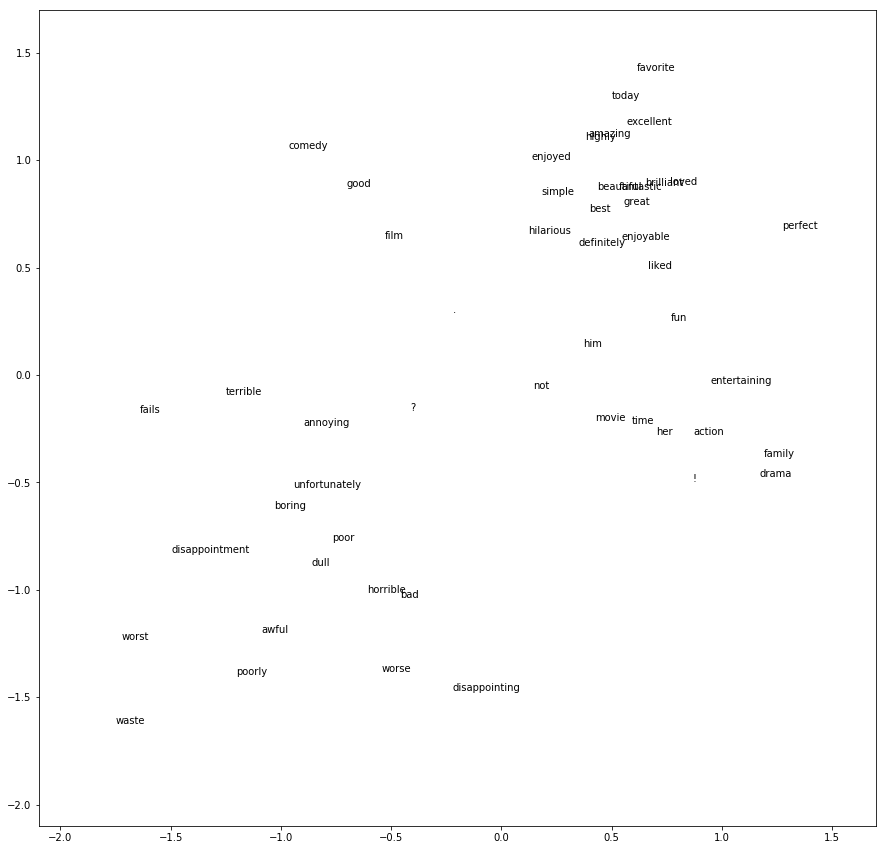

In [22]:
embedding_matrix = classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights')

for term_index in range(len(informative_terms)):
    term_vector = np.zeros(len(informative_terms))
    term_vector[term_index] = 1
    embedding_xy = np.matmul(term_vector, embedding_matrix)
    plt.text(embedding_xy[0],
            embedding_xy[1],
            informative_terms[term_index])
    
plt.rcParams['figure.figsize'] = (15,15)
plt.xlim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.ylim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.show()

In [23]:
# Download the vocabulary file.
terms_url = 'https://download.mlcc.google.com/mledu-datasets/sparse-data-embedding/terms.txt'
terms_path = tf.keras.utils.get_file(terms_url.split('/')[-1], terms_url)

253952/253538 [==============================] - 0s 1us/step


In [27]:
informative_terms = None
with io.open(terms_path,"r", encoding='utf8') as f:
    informative_terms = list(set(f.read().split()))
    
terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(
    key="terms",
    vocabulary_list=informative_terms)

terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[100,100],
  optimizer=my_optimizer
)

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=10000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=10000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=10000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
accuracy 0.9612
accuracy_baseline 0.5
auc 0.9854038
auc_precision_recall 0.98536986
average_loss 0.13459247
label/mean 0.5
loss 3.3648117
precision 0.9692333
prediction/mean 0.4895397
recall 0.95264
global_step 10000
---
Test set metrics:
accuracy 0.8678
accuracy_baseline 0.5
auc 0.94062674
auc_precision_recall 0.9384863
average_loss 0.38792038
label/mean 0.5
loss 9.6980095
precision 0.8852116
prediction/mean 0.4791473
recall 0.8452
global_step 10000
---
